## Entrenamiento de un ML usando Random Forest y el trafico generado por CICIoT2023 

In [68]:
import pandas as pd
import numpy as np
import os
import time 
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Definimos la ruta a la base de datos proporcionada
DATASET_DIRECTORY = '/home/miguel/Escritorio/TFG/TFG Miguel/CICIoT2023/Entrenamientos/Pruebas/Prueba2/'

In [70]:
# Lista de archivos que has proporcionado
csv_files = [
    'BenignTraffic.csv',
    'DDoS.csv',
    'DictionaryBruteForce.pcap_Flow.csv',
    'DoS.csv',
    'Mirai.csv',
    'Recon.csv',
    'Spoofing.csv',
    'Web.csv'
]

In [71]:
# Definimos las columnas de las variables independientes y dependientes
X_columns = [
    'Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet',
    'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total',
    'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
    'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
    'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'Down/Up Ratio', 'Average Packet Size',
    'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg',
    'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes',
    'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
    'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
]
y_column = 'Label'

In [72]:
# Diccionario de clases para simplificar el problema
class_mapping = {
    'DDoS-RSTFINFlood': 'DDoS', 
    'DDoS-PSHACK_Flood': 'DDoS', 
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS', 
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS', 
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS', 
    'DDoS-HTTP_Flood': 'DDoS', 
    
    'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS', 
    'DoS-TCP_Flood': 'DoS', 
    'DoS-HTTP_Flood': 'DoS',

    'Mirai-greeth_flood': 'Mirai', 
    'Mirai-greip_flood': 'Mirai', 
    'Mirai-udpplain': 'Mirai',

    'Recon-PingSweep': 'Recon', 
    'Recon-OSScan': 'Recon', 
    'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon', 
    'Recon-HostDiscovery': 'Recon', 
    
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',

    'BenignTraffic': 'Benign', 
    
    'BrowserHijacking': 'Web',
    'Backdoor_Malware': 'Web', 
    'XSS': 'Web', 
    'Uploading_Attack': 'Web', 
    'SqlInjection': 'Web',
    'CommandInjection': 'Web', 
    
    'DictionaryBruteForce': 'BruteForce'
}


In [74]:
# Inicializamos el escalador y lso dos modelos
scaler = StandardScaler()
random_forest_model = RandomForestClassifier( 
n_estimators= 108, bootstrap= True, ccp_alpha= 0.0, criterion= 'entropy', max_depth= 26,
max_features= 'sqrt', max_samples= 0.5, min_samples_leaf= 3, min_samples_split= 15, random_state=42,n_jobs=-1,
    ) 



In [75]:
# Preprocesamiento y separación de entrenamiento y prueba
print("Preparando los datos...")
training_data = []
for csv_file in tqdm(csv_files):
    # Leer los datos
    data = pd.read_csv(DATASET_DIRECTORY + csv_file)
    # Verificar si todas las columnas existen en el archivo
    missing_columns = [col for col in X_columns if col not in data.columns]
    if missing_columns:
        print(f"Archivo {csv_file} está perdiendo las siguientes columnas: {missing_columns}")
        continue
    # Reetiquetar las clases
    data[y_column] = data[y_column].map(class_mapping).fillna(data[y_column])
    # Contar los valores infinitos y NaN antes de reemplazar/eliminar
    num_inf = data.isin([np.inf, -np.inf]).sum().sum()
    num_nan = data.isna().sum().sum()
    print(f"Archivo {csv_file}: {num_inf} valores infinitos, {num_nan} valores NaN antes de la limpieza")
    # Reemplazar valores infinitos y NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    num_nan_after_replace = data.isna().sum().sum()
    print(f"Archivo {csv_file}: {num_nan_after_replace} valores NaN después de reemplazar infinitos")
    # Mostrar cuántas filas se eliminarían debido a NaN
    rows_before = len(data)
    data.dropna(inplace=True)
    rows_after = len(data)
    print(f"Archivo {csv_file}: Filas antes de eliminar NaN = {rows_before}, Filas después = {rows_after}, Filas eliminadas = {rows_before - rows_after}")
    # Añadir a los datos de entrenamiento si no está vacío
    if not data.empty:
        training_data.append(data)

Preparando los datos...


 38%|███▊      | 3/8 [00:00<00:00,  8.45it/s]

Archivo BenignTraffic.csv: 11 valores infinitos, 3 valores NaN antes de la limpieza
Archivo BenignTraffic.csv: 14 valores NaN después de reemplazar infinitos
Archivo BenignTraffic.csv: Filas antes de eliminar NaN = 17108, Filas después = 17101, Filas eliminadas = 7
Archivo DDoS.csv: 0 valores infinitos, 0 valores NaN antes de la limpieza
Archivo DDoS.csv: 0 valores NaN después de reemplazar infinitos
Archivo DDoS.csv: Filas antes de eliminar NaN = 8554, Filas después = 8554, Filas eliminadas = 0
Archivo DictionaryBruteForce.pcap_Flow.csv: 7 valores infinitos, 1 valores NaN antes de la limpieza
Archivo DictionaryBruteForce.pcap_Flow.csv: 8 valores NaN después de reemplazar infinitos
Archivo DictionaryBruteForce.pcap_Flow.csv: Filas antes de eliminar NaN = 8554, Filas después = 8550, Filas eliminadas = 4


 62%|██████▎   | 5/8 [00:00<00:00,  8.90it/s]

Archivo DoS.csv: 17 valores infinitos, 17 valores NaN antes de la limpieza
Archivo DoS.csv: 34 valores NaN después de reemplazar infinitos
Archivo DoS.csv: Filas antes de eliminar NaN = 8554, Filas después = 8537, Filas eliminadas = 17
Archivo Mirai.csv: 6 valores infinitos, 2 valores NaN antes de la limpieza
Archivo Mirai.csv: 8 valores NaN después de reemplazar infinitos
Archivo Mirai.csv: Filas antes de eliminar NaN = 8554, Filas después = 8550, Filas eliminadas = 4


 88%|████████▊ | 7/8 [00:00<00:00,  9.65it/s]

Archivo Recon.csv: 17 valores infinitos, 5 valores NaN antes de la limpieza
Archivo Recon.csv: 22 valores NaN después de reemplazar infinitos
Archivo Recon.csv: Filas antes de eliminar NaN = 8554, Filas después = 8543, Filas eliminadas = 11
Archivo Spoofing.csv: 6 valores infinitos, 4 valores NaN antes de la limpieza
Archivo Spoofing.csv: 10 valores NaN después de reemplazar infinitos
Archivo Spoofing.csv: Filas antes de eliminar NaN = 8554, Filas después = 8549, Filas eliminadas = 5


100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

Archivo Web.csv: 1 valores infinitos, 1 valores NaN antes de la limpieza
Archivo Web.csv: 2 valores NaN después de reemplazar infinitos
Archivo Web.csv: Filas antes de eliminar NaN = 8554, Filas después = 8553, Filas eliminadas = 1


In [76]:
# Concatenar todos los datos
full_data = pd.concat(training_data, axis=0)

In [77]:
# Dividir en características y etiquetas
X = full_data[X_columns]
y = full_data[y_column]


In [78]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [79]:
# Escalar las características
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Entrenamiento del modelo Random Forest
print("Entrenando el modelo Random Forest...")
random_forest_model.fit(X_train, y_train)

print(random_forest_model.score(X_train, y_train))

#print(cross_val_predict(random_forest_model, X_train, y_train, cv = 5))





Entrenando el modelo Random Forest...
0.7954475296105542


In [81]:
# Evaluación del modelo
start_time = time.time()
y_pred_rf = random_forest_model.predict(X_test)  # Solo predicción
end_time = time.time()
test_time = end_time - start_time
print(f"Tiempo de predicción: {test_time:.4f} segundos")



Tiempo de predicción: 0.1341 segundos


Random Forest Metrics:
Accuracy: 0.7313491031972966
Recall: 0.7151928880454056
Precision: 0.762901741170769
F1 Score: 0.7299554895631644


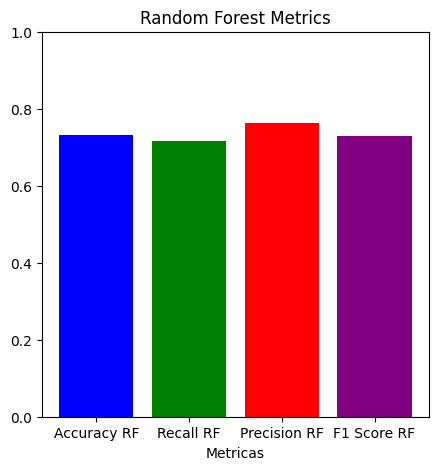

In [82]:


# Métricas para el modelo Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")


# Graficar las métricas
metrics_rf = ['Accuracy RF', 'Recall RF', 'Precision RF', 'F1 Score RF']
values_rf = [accuracy_rf, recall_rf, precision_rf, f1_rf]

plt.figure(figsize=(5, 5))
plt.bar(metrics_rf, values_rf, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.xlabel('Metricas')
plt.title('Random Forest Metrics')
plt.show()


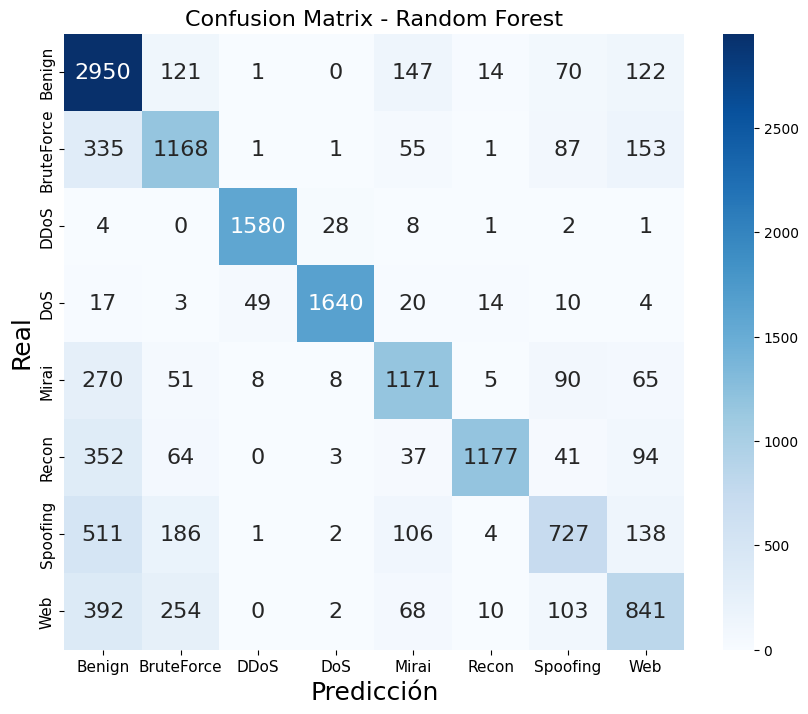

In [83]:
# Matriz de confusión para Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))

# Usar solo una llamada a sns.heatmap
sns.heatmap(conf_matrix_rf, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test),
            annot_kws={"size": 16})  # Ajustar tamaño de los números


plt.xlabel('Predicción', fontsize=18)
plt.ylabel('Real', fontsize=18)
plt.title('Confusion Matrix - Random Forest', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig("/home/miguel/Escritorio/Matrices/Prueba 2/matriz_confusion_modelo9.pdf", format='pdf')
plt.show()
